# Modeling ozone concentration from 222 nm GUV
Lennart Justen  
2023-01-24

**Question:** What is the effect of 222 nm GUV on the concentration of ozone in a small room under different ventilation conditions?

## The lamp
The GUV source used for the calculations in this notebook is filtered, quasi-monochromatic [Ushio's Care222 B1 (narrow) lamp](https://www.ushio.com/files/specifications/care222-filtered-far-uv-c-excimer-lamp-module-technical-data-sheet.pdf).   

![Ushio Care222 B1 lamp spectrum and irradiance](UshioB1_small.png)

## The room
We consider a standard room size with dimensions $3\times 4\times 2.5m$ thus having a surface area $A=12m^2$ and a volume $V=30m^3$

## Ozone generated by 222 nm source
The formula for ozone generation at 222 nm  was provided by Jose Jimenez and goes as follows:
  
$\frac{dO_3}{dt}=2\cdot\sigma_{O_2}C_{O_2}\Phi_{222}$  
  
where  
$\sigma_{O_2}=4.2\times10^{-28} m^2\cdot molecule^{-1}$ is the $O_2$ absorption cross-section at 222 nm at room temp as derived from the [JPL curve](https://uv-vis-spectral-atlas-mainz.org/uvvis_data/cross_sections_plots/Oxygen/O2_200-250nm_lin.jpg),    
$C_{O_2}=5.016\times10^{24} molecule \cdot m^{-3}$ is the concentration of $O_2$ in the air (molecules $m^{-3}$) provided by Jose [here](https://docs.google.com/document/d/1TvsDW0yHq9z6ciUYRPNx_iK7fmwa-SxWte8V51wgeMs/edit),    
$\Phi_{222}$ is the GUV flux at 222 nm (photons $m^{-2} s^{-1}$), and   
the factor of two in front of the ozone generation expression reflects the fact that two $O_3$ molecules are produced per one $O_2$ molecule photolyzed.  
    
$\Phi_{222}$ (photon flux) depends on the radiant power of the source the the resulting concentration of power on a surface (irradiation, $I$). Let's assume that the lamp emits isotropically, and at 1.5m below the lamp the irradiance is a constant $I=6.2\mu W/cm^2$ or $0.062 W/m^2$.   
  
From this, we can calculate the photon flux *i.e.* the number of photons passing through the unit area $ds$ of a spherical shell at radius $r=1.5m$.      
  
$\Phi=\frac{I}{E_{photon}}=\frac{I}{hf}=\frac{I\lambda}{hc}$  
  
where   
$h=6.625\times10^{-34} m^2 \cdot kg \cdot s^{-1}$ is Planck's constant  
$c=2.998\times10^8 m\cdot s^{-1}$ is the speed of light  
$\lambda=222nm$ is the wavelength

In [12]:
import numpy as np
import matplotlib.pyplot as plt

I = 0.062  # Irradiation (W m-2)
wl = 222 * 10**-9  # wavelength (m)


def flux(I, wl):
    # Returns photon flux per unit area (m-2 s-1)
    h = 6.626*10**-34  # Plank's constant (m2 kg s-1)
    c =2.998*10**8  # speed of light (m s-1)
    return (I*wl)/(h*c)

f = flux(I, wl)

With flux defined, the next step in the method Jose shared is the calculate $\frac{dO_3}{dt}$ with the equation given above. I've implemented the approach in the code below, but I also want to flag some uncertanties.  
  
*Thinking about the physical process occuring*  
* At each unit time $dt$, some fixed number of downward-emitted photons are produced by the lamp, equivalent to the photon flux $\Phi$ calculated above.   
* If you imagine the photons spread out over half a spherical shell of radius $r$, some number of photons will impact oxygen molecules that collectively have an area of $dA_{O_2}$ over the entire surface of the half-sphere $dS$ and an area of $da_{O_2}$ over each unit surface elemnent $ds$.  
* Photons that impact O2 will react and produce two O3 molecules. Those that do not impact will continue to the next half-sphere surface at $r+dr$ over the course of time $dt$.  
  
In my understanding of the problem, ozone is emitted at each radius, albeit that the rate of ozone production decreases as $r$ increases, since more photons have already been absorbed by O2 molecules. However, in the current formulation of the problem, ozone is only emmitted at one radius.  
  
To calculate ppm of O3, I propose that we need to calculate the total ozone produced per $dt$ by integrating over the ozone produced at each half-sphere surface of radius $r$ and accounting for photon abosrption. Then, the total ozone produced per $dt$ is divided by the total number of O2 molecules $n_{O_2}$ in the room where $n_{O_2}=C_{O_2}V$. This should give you increase in the concentration of O3 per unit time $dt$.  

In [10]:
def do3_dt(flux):
    # Returns O3 generation per second (molecule m-3 s-1) from lamp source
    # flux = photon flux (m-3 s-1)
    sigma_o2 = 4.2 * 10 ** -28  # O2 absorption cross-section at 222 nm and room temp (m2/molec)
    Co2 = 5.016 * 10 ** 24  # concentration of O2 in the air (molec/m3)
    return 2 * flux * Co2 * sigma_o2

print('Number of ozone molecules created per cubic meter per second = ', do3_dt(f))

Number of ozone molecules created per cubic meter per second =  291943236128643.56


To express ozone concentration in parts per billion (ppb) we use a conversion factor found in Jose's [cheat sheet](https://docs.google.com/document/d/1TvsDW0yHq9z6ciUYRPNx_iK7fmwa-SxWte8V51wgeMs/edit)  

In [11]:
def ppb(co3):
    # Returns ppb of ozone given a concentration (molecules m-3)
    # Assumptions: 1 atm, 298 K, and constant O2 concentration (do2/dt=0)
    ppb_conversion_factor = 1/(2.46*10**16)  # m3/molecule
    return ppb_conversion_factor*co3

print('ppb of ozone generated per second = ', ppb(do3_dt(f)))

ppb of ozone generated per second =  0.01186761122474161


That may not seem like a lot, but when integrated over time, we see that ozone concentration rapidly increases to dangerous levels in the absence of any ventilation

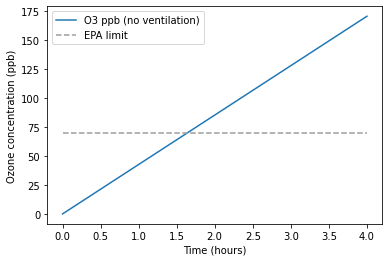

In [18]:
time = np.linspace(0,4, 100)  # time in hours

c_no_vent = np.array([ppb(do3_dt(f))*t*60**2 for t in time])

plt.plot(time, c_no_vent, label='O3 ppb (no ventilation)')
plt.plot(time, [70]*len(time), c='#9d9d9d', linestyle='--', label='EPA limit')

plt.xlabel('Time (hours)')
plt.ylabel('Ozone concentration (ppb)')
plt.legend()
plt.show()

Clearly, this level of ozone generation is unsustainable, but what happens if we add ventilation?

## Ozone concentration with ventilation
Consider that the room is connected to a ventilation system that supplies clean air (no O3 present) at some rate given by *air changes per hour* (ACH), where ACH defines the number of times per hour that the entire volume of air in a given space is exchanged. In this scenario, ozone concentration in the room is depends on the amount of O3 produced by the 222 nm lamp and the depletion of O3 through ventilation. This can be modeled as:  
  
$\frac{dc_{O_3}}{dt}=-c_{O_3}(ACS)+g$  
  
where   
$c_{O_3}$ is the concentration of ozone ($molecules\cdot m^{-3})$,  
$ACS$ is air changes per second ($ACS = ACH/60^2$), units = $s^{-1}$, and  
$g$ is the rate of ozone generation ($molecules\cdot s^{-1}\cdot m^{-3}$) by the 222 nm source as calculated in the last section, where $g = 2\cdot\sigma_{O_2}C_{O_2}\Phi_{222}$ and $\frac{dg}{dt}=0$.  
  
Solving this ordinary differential equation with the initial condition given by $c_{O_3}(0) = 0$, we get  
  
$c_{O_3}(t)=\frac{g}{ACS}(1-e^{-ACS\cdot t})$

In [19]:
def co3(g, ACH, t):
    # Returns concentration of O3 (molecule m-3) as a function of ACH and ozone generation
    # g = rate of O3 generation (molecule m-3 s-1)
    # ACH = air changes per hour = Q/V where Q is air inflow rate (m3 h-1) and V is room volume (m3)

    # Assumptions
    # 1. The air entering the room is contains no O3
    # 2. The concentration of O2 in the room remains unchanged (do2/dt=0)
    # 3. The initial concentration of O3 in the room c(0) = 0

    ACS = ACH/60/60
    return (g/ACS)*(1-np.exp(-ACS*t))

Using the above implementation, lets consider several different ventilation conditions and estimate the buildup of ozone.

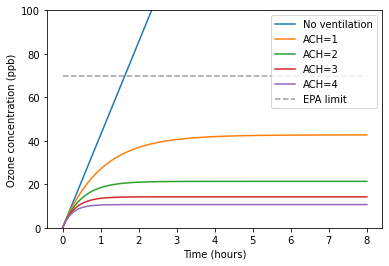

In [24]:
time = np.linspace(0,8, 100)  # time in hours for plotting

# Condition 0: No ventilation
c0 = np.array([ppb(do3_dt(f))*t*60*60 for t in time])

# Condition 1: ACH=1
c1 = np.array([ppb(co3(do3_dt(f),1,t*60*60)) for t in time])

# Condition 2: ACH=2
c2 = np.array([ppb(co3(do3_dt(f),2,t*60*60)) for t in time])

# Condition 3: ACH=3
c3 = np.array([ppb(co3(do3_dt(f),3,t*60*60)) for t in time])

# Condition 4: ACH=4
c4 = np.array([ppb(co3(do3_dt(f),4,t*60*60)) for t in time])


plt.plot(time, c0, label='No ventilation')
plt.plot(time, c1, label='ACH=1')
plt.plot(time, c2, label='ACH=2')
plt.plot(time, c3, label='ACH=3')
plt.plot(time, c4, label='ACH=4')

plt.plot(t, [70]*len(t), c='#9d9d9d', linestyle='--', label='EPA limit')

plt.xlabel('Time (hours)')
plt.ylim([0,100])
plt.ylabel('Ozone concentration (ppb)')
plt.legend()
plt.show()